## Binary Classification with a Software Defects Dataset
Playground Series - Season 3, Episode 23

PROBLEM STATEMENT: PREDICT SOFTWARE DEFECTS
Welcome to the Episode 23 of the Playground Series


Data Description

loc: numeric - McCabe's line count of code

v(g): numeric - McCabe "cyclomatic complexity"

ev(g): numeric - McCabe "essential complexity"

iv(g): numeric - McCabe "design complexity"

n: numeric - Halstead total operators + operands

v: numeric - Halstead "volume"

l: numeric - Halstead "program length"

d: numeric - Halstead "difficulty"

i: numeric - Halstead "intelligence"

e: numeric - Halstead "effort"

b: numeric - Halstead

t: numeric - Halstead's time estimator

lOCode: numeric - Halstead's line count

lOComment: numeric - Halstead's count of lines of comments

lOBlank: numeric - Halstead's count of blank lines

lOCodeAndComment: numeric

uniq_Op: numeric - unique operators

uniq_Opnd: numeric - unique operands

total_Op: numeric - total operators

total_Opnd: numeric - total operands

branchCount: numeric - percentage of the flow graph

defects: {false, true} - module has/has not one or more reported defects

Objective: Binary Classification on Defects, predict the probability of defect

Metric of Evaluation: ROC-AUC





## INTRO
이번 대회는 구글 부트 캠프 수료 조건을 충족하기 위해 부트캠프 스터디에서 만난 팀원들과 나간 나의 첫 캐글 대회이다. 다른 팀원들 모두 인공지능 분야 공부를 시작한지 별로 안돼서 가장 쉽고 간단한 대회를 나가기로 했다. 팀 결성도 뒤 늦게 돼서 대회를 9일 남겨두고 참가하게 됐다.

이 경험을 통해 일단 12프로안에 들어 수료 조건을 충족하긴 했지만 나의 개념공부가 정말 약하게 쌓아졌다는걸 느꼈다. 제대로 몰입해서 하지는 못했지만 그래도 나름 몇 개월 개념 공부를 열심히 했다고 생각했는데 다시 한 번 개념을 다 잡고 여러 실습을 해야하는걸 느꼈다.

## CONCLUSION
아쉬웠던 점은 시간이 부족해 튜닝을 제대로 못해본것과 이 코드에 팀원들이 얘기했던 log trans와 여러 전처리과정을 추가하지 못했던 것이 아쉽다. 우리 팀은 이 코드에서 나온 결과와 다른 팀원 분이 찾아오신 베이스라인 코드를 기반으로 한 결과 2개를 제출했다(단순히 public score가 가장 높은걸 골랐다). 최종적으로 나온 Private score는 예상치 못하게 최종적으로 고르지 않은 Submission에서 나왔다. 아직도 정확한 채점 방식과 결과산정을 이해하지 못해 대표 제출을 제대로 못 고른 아쉬움도 있다...젤 높았던 점수대로 하면 동메달을 받을 수 있었어서 더 아쉬운거 같다.


## IMPORT


In [2]:
!pip install catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf
import seaborn as sns
from tqdm import tqdm
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier


pd.set_option('display.max_columns', None)
# 모든 columns를 생략하지 말고 다 보여준다.
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
warnings.filterwarnings('ignore')

In [4]:
train_data = pd.read_csv('/content/drive/MyDrive/캐글 software defects prediction/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/캐글 software defects prediction/test.csv')
origin = pd.read_csv('/content/drive/MyDrive/캐글 software defects prediction/jm1.csv')

In [5]:
# 원본 데이터에 있는 ?값을 사용가능하게 변경했다
columns = ['uniq_Op','uniq_Opnd','total_Op','total_Opnd','branchCount']

for col in columns:
    origin[col][origin[col] == '?'] = np.nan
    origin[col] = origin[col].astype(float)


In [6]:
train_data = pd.concat([train_data,origin],ignore_index=True)
train_data = train_data.drop_duplicates()

* 이 대회에는 원본 데이터가 따로 있어 그것을 합쳐서 사용했다.

## Explolatory Data Analysis And Feature Engineering

데이터 시각화 과정을 거치면서 데이터를 살펴봤지만 대회 데이터 특성상 Feature engineering보다는 모델링에 더 많은 신경을 써야하겠다라고 생각했다. 데이터 사이에 큰 의미와 연관성이 내 수준에서는 보이지 않았고 다른 사람들은 약간의 engineering과정을 거쳤지만 내가 직관적으로 이해가 갔던 부분들만 손을 댔다.

* 데이터의 분포를 살펴봤을때 이상치가 보여 아웃 라이어를 제거하는 함수를 만들어 사용

* 데이터 자체가 분포가 치우져 있어 Standard Scaler를 진행
 * log transformer가 좋다는 팀원의 의견으로 추후에 이것도 진행

* feature 중 'l'의 상관관계를 살펴본 결과 양수로 전환하는게 좋아 보여 1.0 - data['l'] 진행
 * 상관관계 분석을 통해 여러 피쳐들 합쳐 병합하는 과정도 해보자는 의견으로 진행해본 결과 점수가 더 낮게 나와 진행하지 않음




In [7]:
train_data

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0.0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,0.09,302.71,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1.0,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,0.05,52.04,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2.0,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,0.07,97.45,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3.0,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,0.03,26.31,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4.0,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,0.02,20.31,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112643,NaN,18.0,4.0,1.0,4.0,52.0,241.48,0.14,7.33,32.93,1770.86,0.08,98.38,13,0,2,0,10.0,15.0,30.0,22.0,7.0,False
112644,NaN,9.0,2.0,1.0,2.0,30.0,129.66,0.12,8.25,15.72,1069.68,0.04,59.43,5,0,2,0,12.0,8.0,19.0,11.0,3.0,False
112645,NaN,42.0,4.0,1.0,2.0,103.0,519.57,0.04,26.40,19.68,13716.72,0.17,762.04,29,1,10,0,18.0,15.0,59.0,44.0,7.0,False
112646,NaN,10.0,1.0,1.0,1.0,36.0,147.15,0.12,8.44,17.44,1241.57,0.05,68.98,6,0,2,0,9.0,8.0,21.0,15.0,1.0,False


In [8]:
train_data.describe()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,110675.000000,110675.000000,110675.000000,110675.000000,110675.000000,110675.000000,110675.000000,110675.000000,110675.000000,1.106750e+05,110675.000000,1.106750e+05,110675.000000,110675.000000,110675.000000,110675.000000,110670.000000,110670.000000,110670.000000,110670.000000,110670.000000
mean,50881.000000,38.281130,5.639227,2.925660,3.583252,99.755611,559.592214,0.110634,13.893386,28.036422,2.276492e+04,0.186308,1.248926e+03,23.460646,1.896960,4.101785,0.216481,11.940627,15.904746,59.459729,40.509986,10.104982
std,29376.592059,57.481747,8.590501,4.915292,6.020464,181.512388,1360.736624,0.100723,14.667762,24.304949,2.279499e+05,0.452096,1.211421e+04,41.342956,6.326917,6.856521,1.129491,7.122089,19.166969,110.752116,75.487075,15.495022
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25440.500000,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.040000,5.600000,15.530000,5.648200e+02,0.030000,3.140000e+01,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,50881.000000,23.000000,3.000000,1.000000,2.000000,52.000000,235.230000,0.080000,10.000000,23.430000,2.343810e+03,0.080000,1.305000e+02,14.000000,0.000000,2.000000,0.000000,12.000000,12.000000,31.000000,21.000000,5.000000
75%,76321.500000,43.000000,6.000000,3.000000,4.000000,113.000000,575.840000,0.140000,18.290000,34.820000,1.043613e+04,0.190000,5.795300e+02,27.000000,1.000000,5.000000,0.000000,16.000000,20.000000,68.000000,45.000000,11.000000
max,101762.000000,3442.000000,470.000000,165.000000,402.000000,8441.000000,80843.080000,1.300000,418.200000,569.780000,3.107978e+07,26.950000,1.726655e+06,2824.000000,344.000000,447.000000,108.000000,411.000000,1026.000000,5420.000000,3021.000000,826.000000


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67842 entries, 0 to 67841
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 67842 non-null  int64  
 1   loc                67842 non-null  float64
 2   v(g)               67842 non-null  float64
 3   ev(g)              67842 non-null  float64
 4   iv(g)              67842 non-null  float64
 5   n                  67842 non-null  float64
 6   v                  67842 non-null  float64
 7   l                  67842 non-null  float64
 8   d                  67842 non-null  float64
 9   i                  67842 non-null  float64
 10  e                  67842 non-null  float64
 11  b                  67842 non-null  float64
 12  t                  67842 non-null  float64
 13  lOCode             67842 non-null  int64  
 14  lOComment          67842 non-null  int64  
 15  lOBlank            67842 non-null  int64  
 16  locCodeAndComment  678

In [11]:
train_data.drop(['id'],axis=1,inplace=True)
train_data


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,0.09,302.71,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,0.05,52.04,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,0.07,97.45,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,0.03,26.31,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,0.02,20.31,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112643,18.0,4.0,1.0,4.0,52.0,241.48,0.14,7.33,32.93,1770.86,0.08,98.38,13,0,2,0,10.0,15.0,30.0,22.0,7.0,False
112644,9.0,2.0,1.0,2.0,30.0,129.66,0.12,8.25,15.72,1069.68,0.04,59.43,5,0,2,0,12.0,8.0,19.0,11.0,3.0,False
112645,42.0,4.0,1.0,2.0,103.0,519.57,0.04,26.40,19.68,13716.72,0.17,762.04,29,1,10,0,18.0,15.0,59.0,44.0,7.0,False
112646,10.0,1.0,1.0,1.0,36.0,147.15,0.12,8.44,17.44,1241.57,0.05,68.98,6,0,2,0,9.0,8.0,21.0,15.0,1.0,False


In [13]:
columns = ['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']
for col in columns:
    print(train_data[col].isnull().sum(),f'{col}의 null 개수 ')


0 loc의 null 개수 
0 v(g)의 null 개수 
0 ev(g)의 null 개수 
0 iv(g)의 null 개수 
0 n의 null 개수 
0 v의 null 개수 
0 l의 null 개수 
0 d의 null 개수 
0 i의 null 개수 
0 e의 null 개수 
0 b의 null 개수 
0 t의 null 개수 
0 lOCode의 null 개수 
0 lOComment의 null 개수 
0 lOBlank의 null 개수 
0 locCodeAndComment의 null 개수 
5 uniq_Op의 null 개수 
5 uniq_Opnd의 null 개수 
5 total_Op의 null 개수 
5 total_Opnd의 null 개수 
5 branchCount의 null 개수 


In [14]:
train_data.dropna(axis=0,inplace=True)

In [15]:
for col in columns:
    print(train_data[col].isnull().sum(),f'{col}의 null 개수 ')

0 loc의 null 개수 
0 v(g)의 null 개수 
0 ev(g)의 null 개수 
0 iv(g)의 null 개수 
0 n의 null 개수 
0 v의 null 개수 
0 l의 null 개수 
0 d의 null 개수 
0 i의 null 개수 
0 e의 null 개수 
0 b의 null 개수 
0 t의 null 개수 
0 lOCode의 null 개수 
0 lOComment의 null 개수 
0 lOBlank의 null 개수 
0 locCodeAndComment의 null 개수 
0 uniq_Op의 null 개수 
0 uniq_Opnd의 null 개수 
0 total_Op의 null 개수 
0 total_Opnd의 null 개수 
0 branchCount의 null 개수 


Text(0, 0.5, 'percentage')

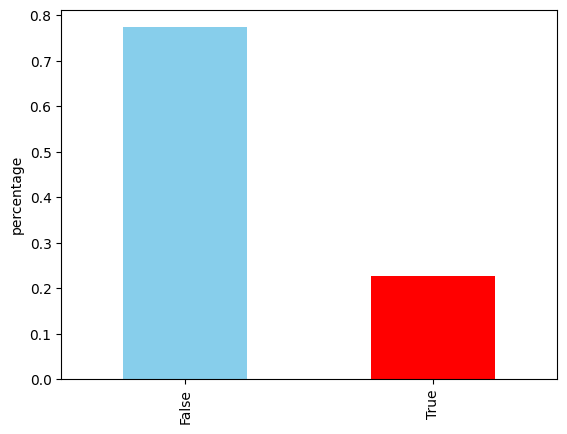

In [17]:
train_data['defects'].value_counts(normalize=True).plot(kind='bar',color=['skyblue','red'])
plt.ylabel('percentage')

* 데이터 불균형이 보인다. class_weight을 통해 해소해 봐야겠다.


Text(0.5, 1.0, 'Correlations')

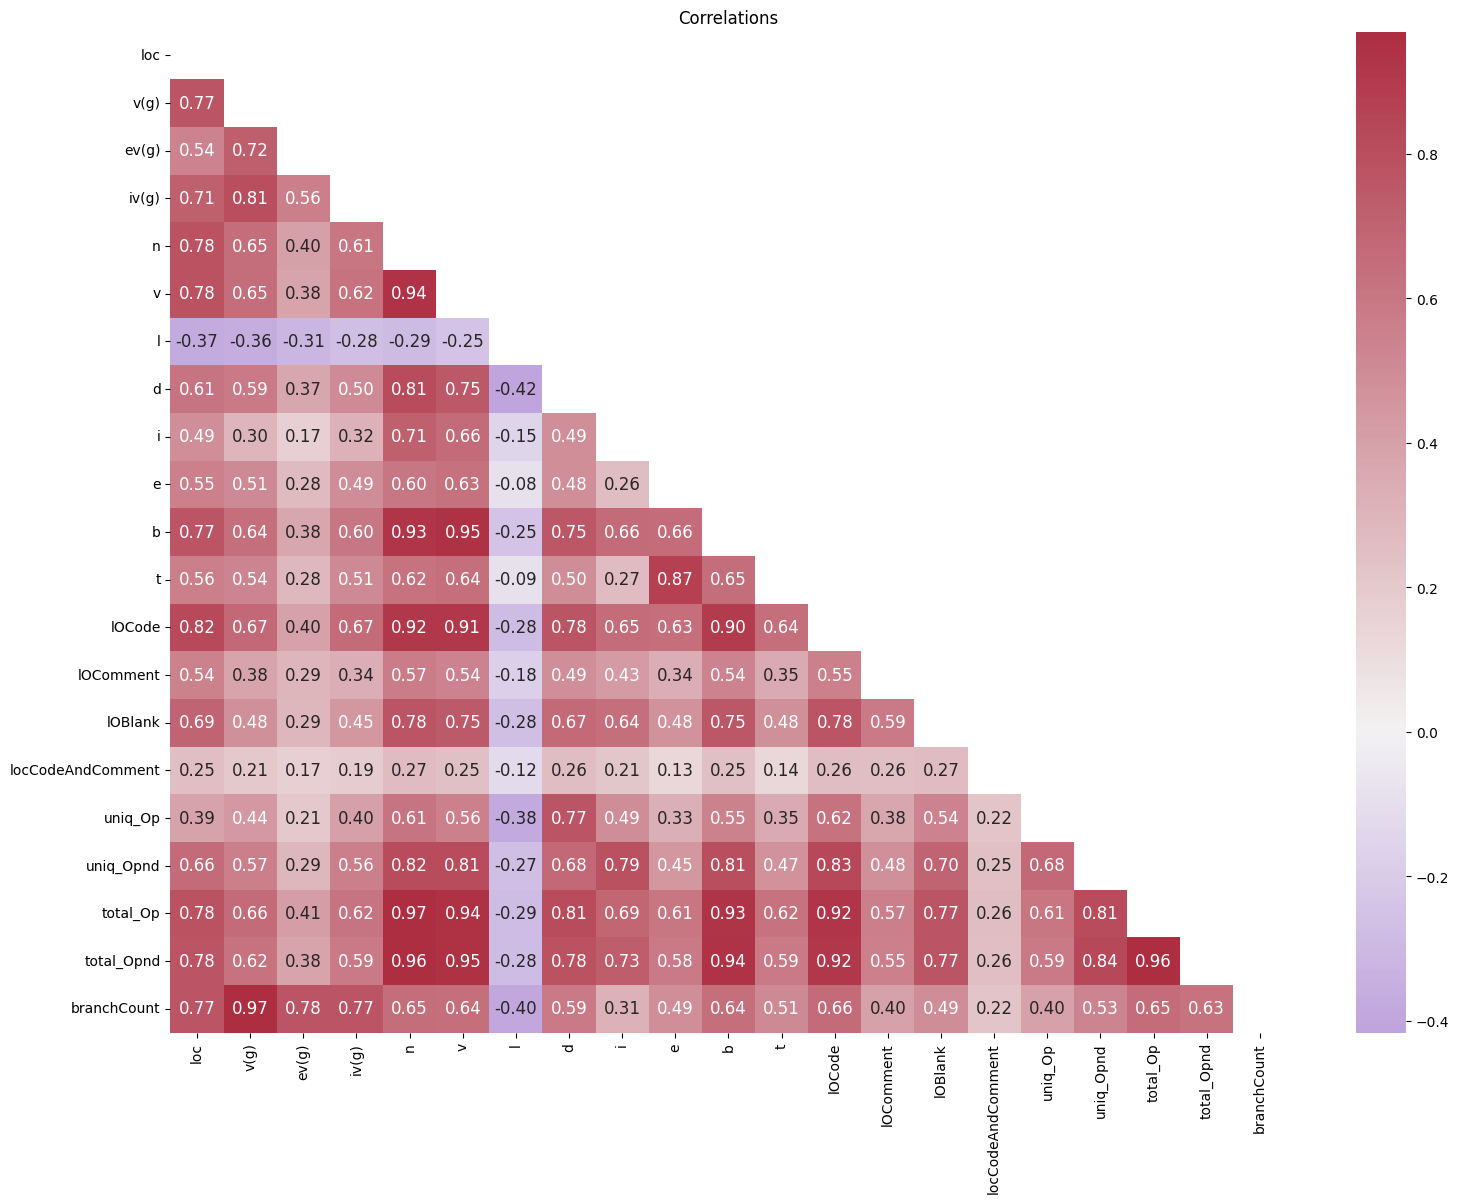

In [18]:
data_corr = train_data.drop(columns= ['defects'],axis=1).corr()
data_mask = np.triu(np.ones_like(data_corr,dtype=bool))
cmap = sns.diverging_palette(1000,7,s=75,l=40,n=20,center='light',as_cmap=True)
f,ax = plt.subplots(figsize=(18,13))
sns.heatmap(data_corr,annot=True,cmap=cmap,fmt = '.2f',center=0,annot_kws={'size':12},mask=data_mask).set_title('Correlations')

* l값만이 음수의 상관관계를 가지는게 이상해 바꿔주겠다.
 * 삭제도 해봤지만 점수가 더 낮게 나왔다.

In [19]:
test_data['l'] = 1.0 - test_data['l']
train_data['l'] = 1.0 - train_data['l']

In [20]:
train_data['defects'] = train_data['defects'].astype(float)

In [21]:
train_data

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.94,19.56,14.25,5448.79,0.09,302.71,17,1,1,0,16.0,9.0,38.0,22.0,5.0,0.0
1,14.0,2.0,1.0,2.0,32.0,151.27,0.86,7.00,21.11,936.71,0.05,52.04,11,0,1,0,11.0,11.0,18.0,14.0,3.0,0.0
2,11.0,2.0,1.0,2.0,45.0,197.65,0.89,8.05,22.76,1754.01,0.07,97.45,8,0,1,0,12.0,11.0,28.0,17.0,3.0,0.0
3,8.0,1.0,1.0,1.0,23.0,94.01,0.81,5.25,17.86,473.66,0.03,26.31,4,0,2,0,8.0,6.0,16.0,7.0,1.0,1.0
4,11.0,2.0,1.0,2.0,17.0,60.94,0.82,5.63,12.44,365.67,0.02,20.31,7,0,2,0,7.0,6.0,10.0,10.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112643,18.0,4.0,1.0,4.0,52.0,241.48,0.86,7.33,32.93,1770.86,0.08,98.38,13,0,2,0,10.0,15.0,30.0,22.0,7.0,0.0
112644,9.0,2.0,1.0,2.0,30.0,129.66,0.88,8.25,15.72,1069.68,0.04,59.43,5,0,2,0,12.0,8.0,19.0,11.0,3.0,0.0
112645,42.0,4.0,1.0,2.0,103.0,519.57,0.96,26.40,19.68,13716.72,0.17,762.04,29,1,10,0,18.0,15.0,59.0,44.0,7.0,0.0
112646,10.0,1.0,1.0,1.0,36.0,147.15,0.88,8.44,17.44,1241.57,0.05,68.98,6,0,2,0,9.0,8.0,21.0,15.0,1.0,0.0


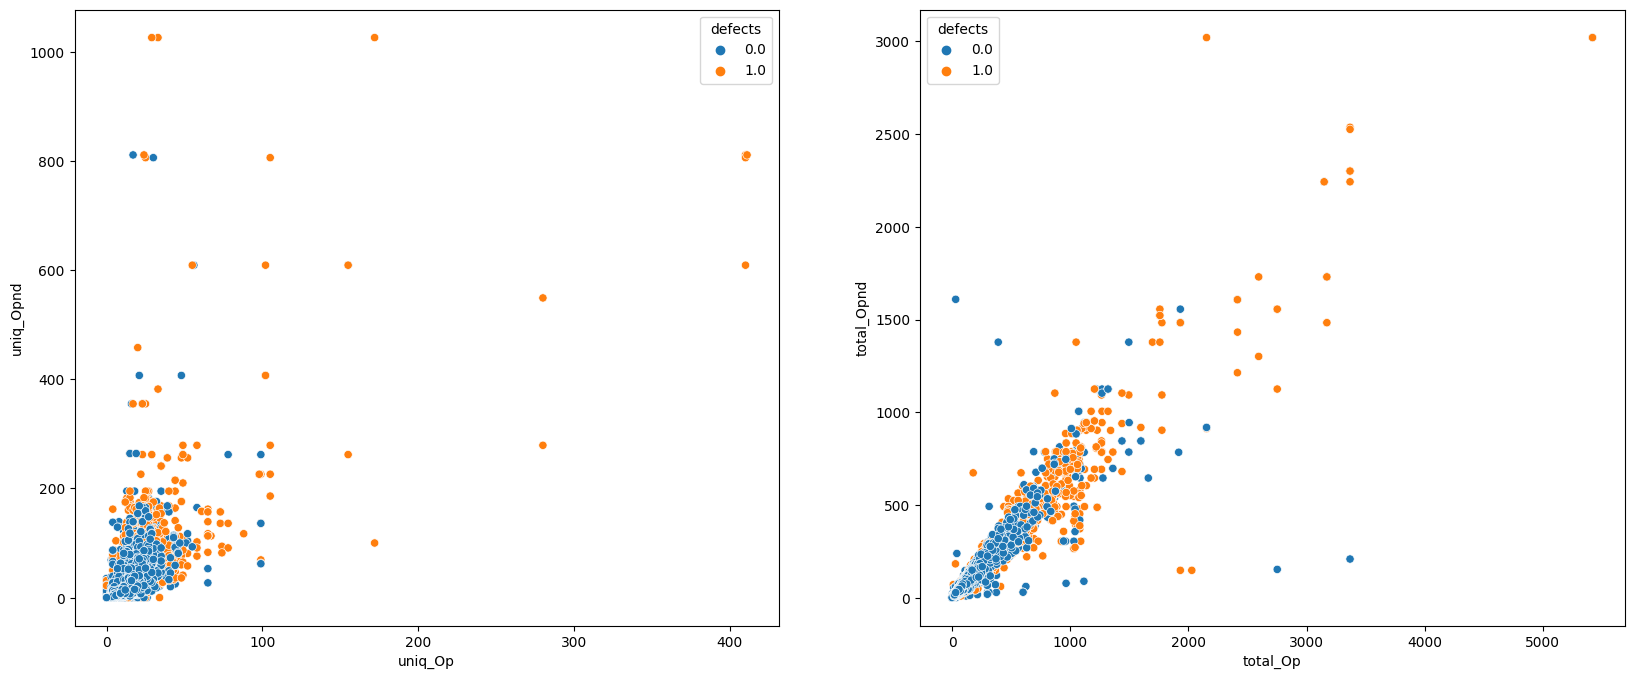

In [32]:
fig, axes = plt.subplots(1, 2, figsize = (20,8))

sns.scatterplot(ax = axes[0], data = train_data, x = 'uniq_Op', y = 'uniq_Opnd', hue = 'defects');
sns.scatterplot(ax = axes[1], data = train_data, x = 'total_Op', y = 'total_Opnd', hue = 'defects');

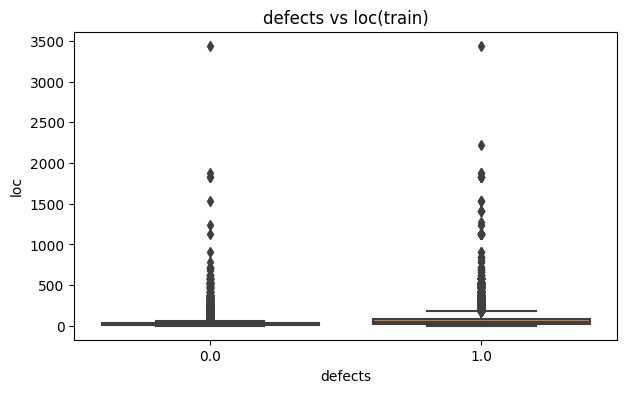

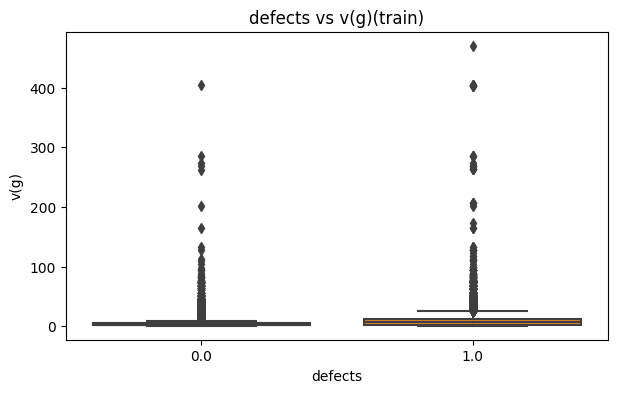

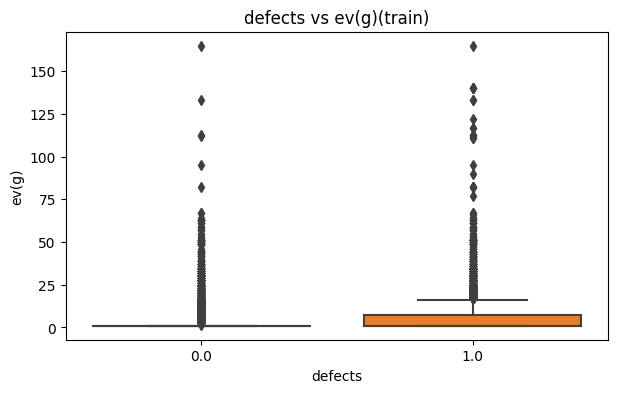

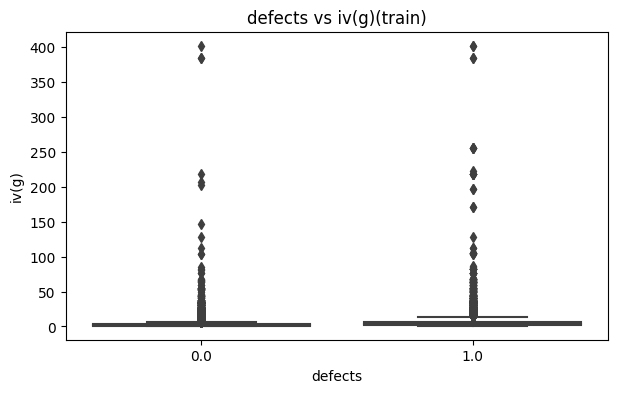

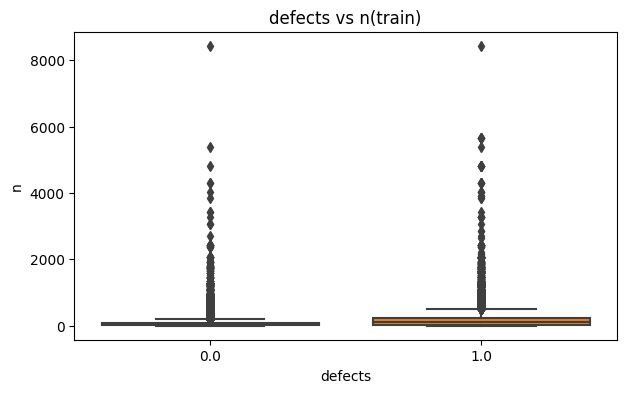

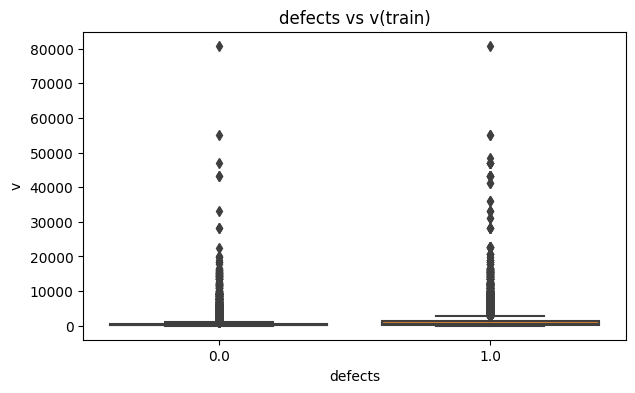

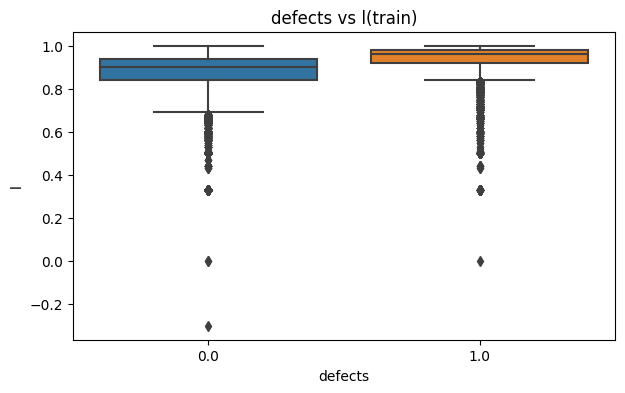

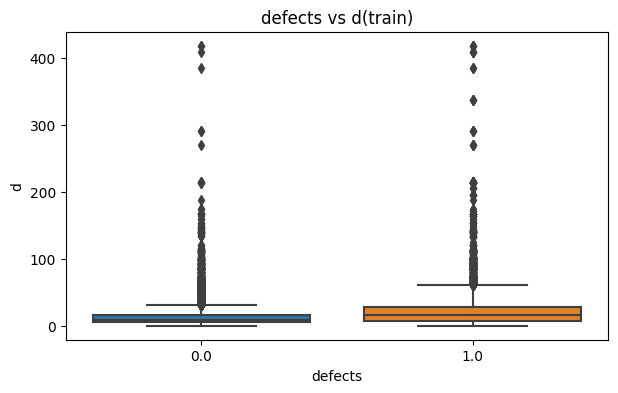

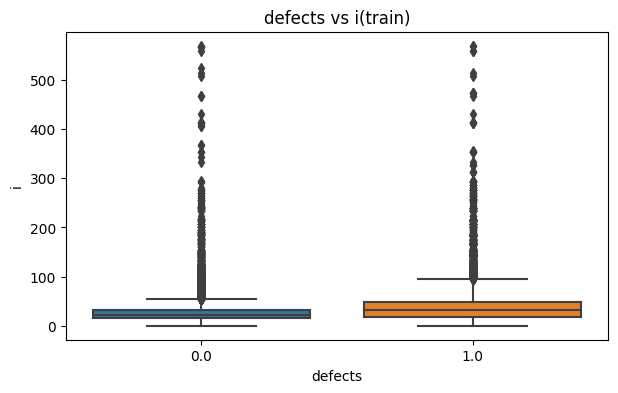

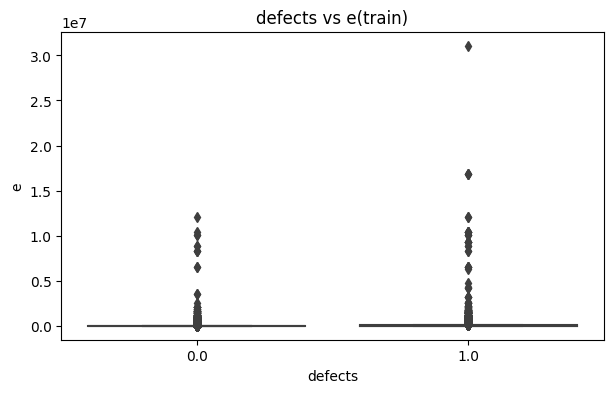

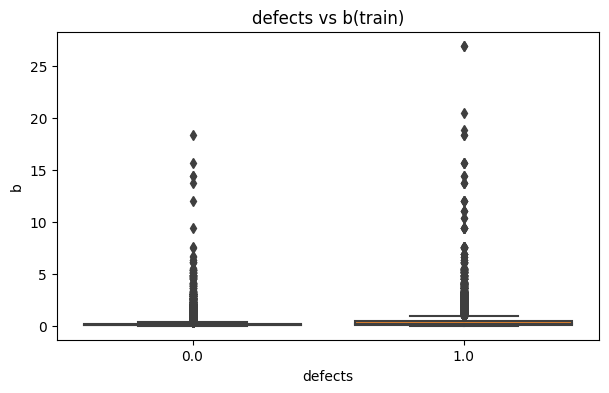

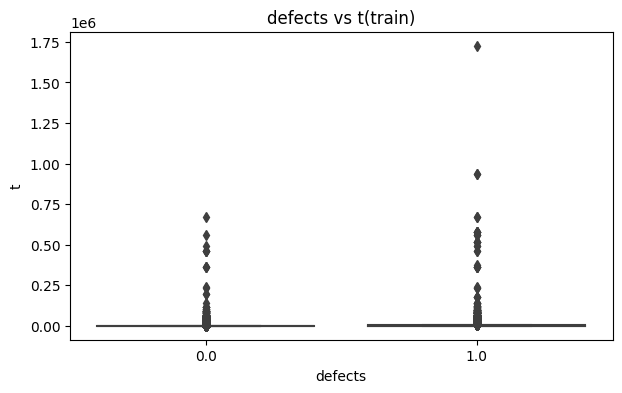

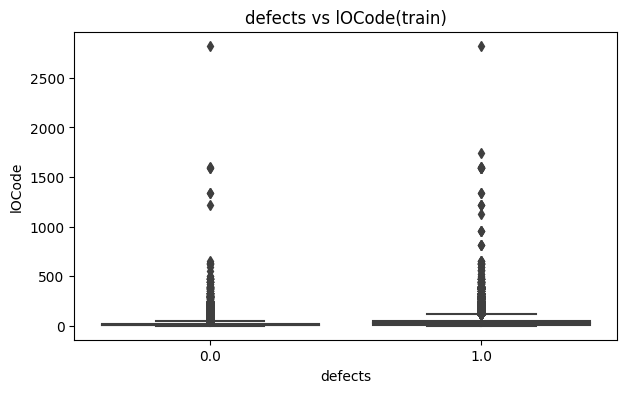

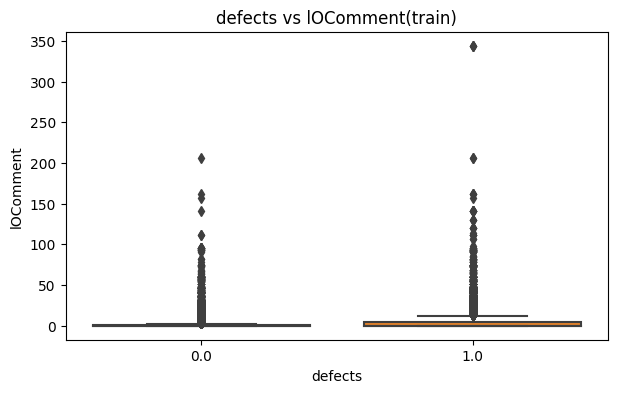

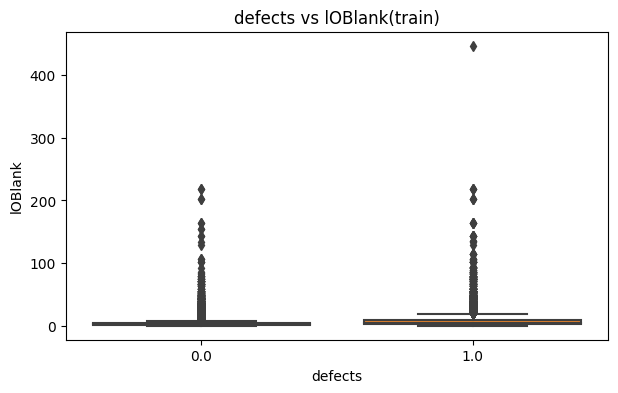

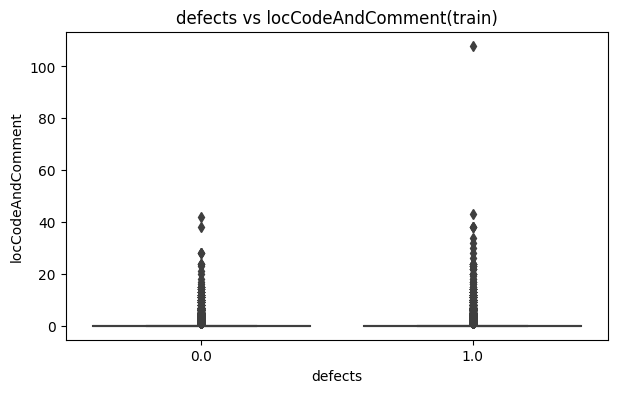

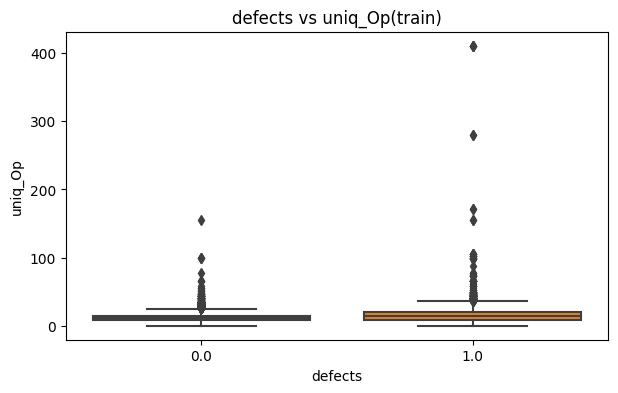

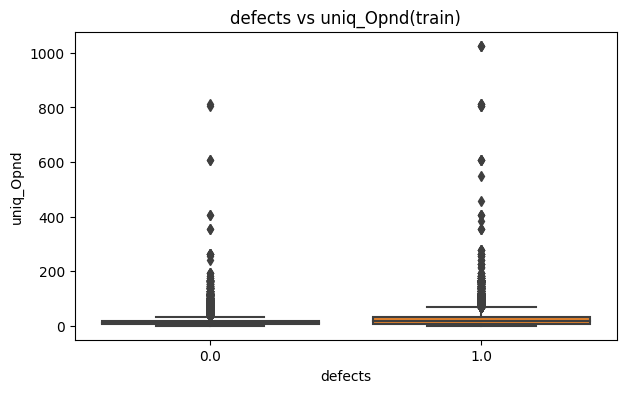

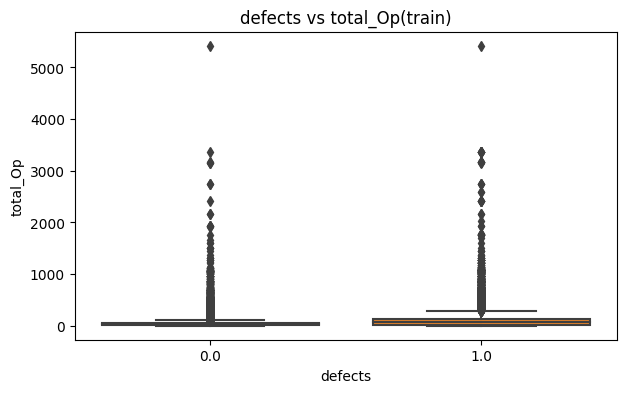

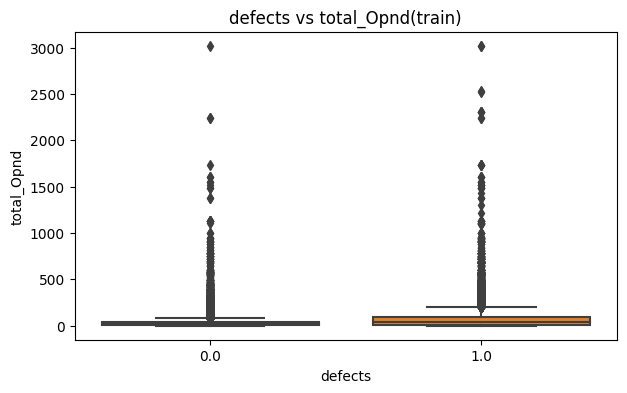

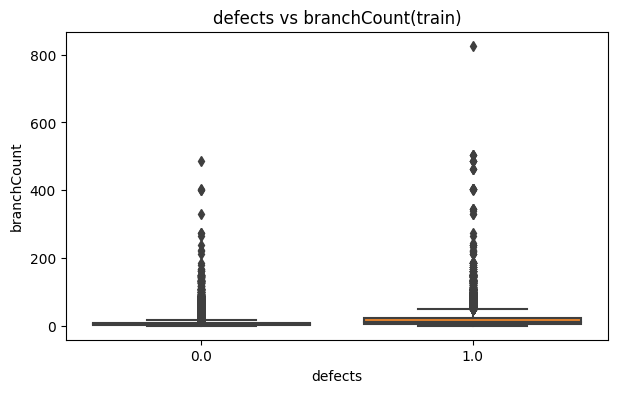

In [45]:
columns = ['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']
for col in columns:
      plt.figure(figsize=(7,4))
      sns.boxplot(train_data,x='defects',y=col)
      plt.gca().set_title(f'defects vs {col}(train)')
      plt.show()

* 이상치가 다수 발견돼서 제거하겠다.

In [46]:
def iqr_outlier_detection(data):

    q1, q3 = np.percentile(data, [25, 75])

    iqr = q3 - q1

    threshold = iqr * 1.5
    outliers = [x for x in data if x < q1 - threshold or x > q3 + threshold]

    data_filtered = data[~np.isin(data, outliers)]

    return data_filtered

In [47]:
for col in train_data.columns:
  iqr_outlier_detection(train_data[col])

In [ ]:
def add_feat(X):
    df=X.copy()
    df['mean_bnv']         = (df['n'] + df['v'] + df['b']) /3;
    df['mean_uniqOpOpend'] = (df['uniq_Op'] + df['uniq_Opnd']) /2;
    df['mean_totOpOpend']  = (df['total_Op'] + df['total_Opnd']) /2;
    df['mean_brcntvg']     = (df['branchCount'] + df['v(g)']) / 2;
    return df
train_data = add_feat(train_data)
test_data = add_feat(test_data)
# 이거 해보겠다 이전에는 리더보드 0.7904   하니까 점수가 더 안 나온

* 이 부분은 비슷한 상관계수를 가진 피쳐들끼리 병합해서 데이터를 정리하는게 좋을거 같다는 팀원의 의견으로 추가해봤지만 최종적으로 사용하지는 못했다

In [48]:
train_data

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.94,19.56,14.25,5448.79,0.09,302.71,17,1,1,0,16.0,9.0,38.0,22.0,5.0,0.0
1,14.0,2.0,1.0,2.0,32.0,151.27,0.86,7.00,21.11,936.71,0.05,52.04,11,0,1,0,11.0,11.0,18.0,14.0,3.0,0.0
2,11.0,2.0,1.0,2.0,45.0,197.65,0.89,8.05,22.76,1754.01,0.07,97.45,8,0,1,0,12.0,11.0,28.0,17.0,3.0,0.0
3,8.0,1.0,1.0,1.0,23.0,94.01,0.81,5.25,17.86,473.66,0.03,26.31,4,0,2,0,8.0,6.0,16.0,7.0,1.0,1.0
4,11.0,2.0,1.0,2.0,17.0,60.94,0.82,5.63,12.44,365.67,0.02,20.31,7,0,2,0,7.0,6.0,10.0,10.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112643,18.0,4.0,1.0,4.0,52.0,241.48,0.86,7.33,32.93,1770.86,0.08,98.38,13,0,2,0,10.0,15.0,30.0,22.0,7.0,0.0
112644,9.0,2.0,1.0,2.0,30.0,129.66,0.88,8.25,15.72,1069.68,0.04,59.43,5,0,2,0,12.0,8.0,19.0,11.0,3.0,0.0
112645,42.0,4.0,1.0,2.0,103.0,519.57,0.96,26.40,19.68,13716.72,0.17,762.04,29,1,10,0,18.0,15.0,59.0,44.0,7.0,0.0
112646,10.0,1.0,1.0,1.0,36.0,147.15,0.88,8.44,17.44,1241.57,0.05,68.98,6,0,2,0,9.0,8.0,21.0,15.0,1.0,0.0


In [49]:
X_train = train_data.drop(['defects'],axis=1)
Y_train = train_data['defects']

In [50]:
X_test = test_data.drop('id',axis=1)

In [51]:
X_test.shape

(67842, 21)

In [52]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modeling
다양한 사람들의 모델링을 찾아서 공부했지만 내 수준에서 직접 간단하게라도 모델을 만들어 보는게 좋을거 같아서 욕심 부리지 않고 기본에 충실했다.

* 4개의 classifier와 파라미터 튜닝 과정을 거쳐 마지막에 VotingClassifier를 통해 최종적으로 예측했다.

* 과적합 방지를 위해 Cross-Validation을 이용했으며 StratifiedKFold를 사용했다. 가장 기본적인걸 사용했다.

* GridSearch를 통해 튜닝을 했다. BayesianOptimization도 고려해봤지만 GridSeach가 조금 더 높게 나오는거 같아서 이걸로 정했다.






In [54]:
skf = StratifiedKFold(n_splits = 10, shuffle=True,random_state=42)

In [ ]:

params_lgbm = { 'boosting_type' : 'gbdt',
        'objective' : 'binary','colsample_bytree': 1.0,
                'learning_rate': 0.1, 'min_child_samples': 1200,
                'num_leaves': 20, 'reg_alpha': 9, 'reg_lambda': 1, 'subsample': 1.0}
lgbm = LGBMClassifier(**params_lgbm)
scores = cross_val_score(lgbm,
                         X_train,
                         Y_train,
                         scoring = 'roc_auc',
                         cv = skf,
                         n_jobs = -1)
print(f'{lgbm.__class__.__name__} auroc score : {scores.mean()}')

# without params : : 0.7838295914922109
# with params : 0.785606200470542
#with bayesLGBMClassifier auroc score : LGBMClassifier auroc score : 0.7822087973881666

# 2023 - 10 - 22 19:03  : 0.7857492663051321
# with 특성 열 평균값 데이터 특성 추가후 : 0.7856197091206304

LGBMClassifier auroc score : 0.7856197091206304


In [ ]:
'''!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

def lgbm_cl_bo(min_child_samples,colsample_bytree,learning_rate,num_leaves,reg_alpha,reg_lambda):
  params_lgbm = {}
  params_lgbm['min_child_samples'] = round(min_child_samples)
  params_lgbm['colsample_bytree'] = colsample_bytree
  params_lgbm['learning_rate'] = learning_rate
  params_lgbm['num_leaves'] = round(num_leaves)
  params_lgbm['reg_alpha'] = reg_alpha
  params_lgbm['reg_lambda'] = reg_lambda
  params_lgbm['boosting_type'] = 'gbdt'
  params_lgbm['objective'] = 'binary'
  params_lgbm['subsample'] = 1.0
  params_lgbm['max_bin'] = 1023
  params_lgbm['n_jobs'] = -1

  scores = cross_val_score(LGBMClassifier(**params_lgbm,random_state=2920,silent=True),X_train,Y_train,scoring='roc_auc',cv=5).mean()
  score = scores.mean()
  return score

params_lgbm = {'min_child_samples':(800,1200),
               'colsample_bytree':(0.3,1.0),
               'learning_rate':(0.005,0.1),
               'num_leaves' : (20,60),
               'reg_alpha' : (0.0,10.0),
               'reg_lambda' : (0.0,5.0)

               }

lgbm_bo = BayesianOptimization(lgbm_cl_bo,params_lgbm,random_state=2920)
lgbm_bo.maximize(n_iter=30,init_points=20)'''

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold


def find_best_hyperparameters(X_train, Y_train):

    # 하이퍼파라미터 후보를 설정합니다.
    hyperparameters = {

        'min_child_samples' : (800,1200),
        'colsample_bytree' : (0.3,1.0),
        'learning_rate' : (0.005,0.1),
        'num_leaves' : (20,60),
        'reg_alpha' : (0.0,10.0),
        'reg_lambda' : (0.0,10.0),
        'subsample' : (0.0,1.0)
    }

    # 교차 검증을 사용하여 하이퍼파라미터를 탐색합니다.
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(LGBMClassifier(), hyperparameters, cv=cv, scoring='roc_auc')
    grid_search.fit(X_train, Y_train)

    # 최적의 하이퍼파라미터를 반환합니다.
    return grid_search.best_params_


# 하이퍼파라미터를 찾습니다.
hyperparameters = find_best_hyperparameters(X_train, Y_train)

# 최적의 하이퍼파라미터를 출력합니다.
print(hyperparameters)

In [ ]:

cat_params = {'od_type' : 'Iter','eval_metric' : 'AUC',
                         'loss_function' : 'Logloss','bootstrap_type':'Bayesian', "max_bin": 200,'depth': 8, 'l2_leaf_reg': 1.0, 'learning_rate': 0.01, 'random_strength': 0.0}


cat = CatBoostClassifier(verbose = False,**cat_params)
scores = cross_val_score(cat,
                        X_train,
                        Y_train,
                        scoring = 'roc_auc',
                        cv = skf,
                        n_jobs = -1)
print(f'{cat.__class__.__name__} auroc score: {scores.mean()}')

# without params :  0.7829769325555607
# CatBoostClassifier auroc score: 0.7848582234693893
#CatBoostClassifier auroc score: 0.7848582374489382
# with 특성 열 평균값 데이터 특성 추가후: 0.7848988181018993



CatBoostClassifier auroc score: 0.7848988181018993


'param = {\n      "random_state":42,\n      \'learning_rate\' : trial.suggest_loguniform(\'learning_rate\', 0.01, 0.3),\n      \'bagging_temperature\' :trial.suggest_loguniform(\'bagging_temperature\', 0.01, 100.00),\n      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),\n      "max_depth":trial.suggest_int("max_depth", 4, 16),\n      \'random_strength\' :trial.suggest_int(\'random_strength\', 0, 100),\n      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),\n      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),\n      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),\n      "max_bin": trial.suggest_int("max_bin", 200, 500),\n      \'od_type\': trial.suggest_categorical(\'od_type\', [\'IncToDec\', \'Iter\']),\n  }'

In [ ]:
def find_best_hyperparameters(X_train, Y_train):

   # 하이퍼파라미터 후보를 설정합니다.
  hyperparameters = {
        'learning_rate': (0.01,0.1),
        "depth":(4, 8),
        'random_strength' :(0.0,1.0),
         "l2_leaf_reg": (0.0,1.0)
        #'n_estimators': np.arange(10, 100, 10),
        #'max_leaves' :(10,60),
        #'rsm' : ( 0.0,1.0),
        #"min_child_samples": ( 5, 100),
         }
    # 교차 검증을 사용하여 하이퍼파라미터를 탐색합니다.
  cv = KFold(n_splits=5, shuffle=True, random_state=42)
  grid_search = GridSearchCV(CatBoostClassifier(), hyperparameters, cv=cv, scoring='roc_auc')
  grid_search.fit(X_train, Y_train)
    # 최적의 하이퍼파라미터를 반환합니다.
  return grid_search.best_params_


# 하이퍼파라미터를 찾습니다.
hyperparameters = find_best_hyperparameters(X_train, Y_train)

# 최적의 하이퍼파라미터를 출력합니다.
print(hyperparameters)

In [ ]:
xgb_params = {'n_estimators': 1000,
    'learning_rate': 0.0175,
    'booster': 'gbtree',
    'lambda': 0.0815,
    'alpha': 0.075,
    'subsample': 0.506,
    'colsample_bytree': 0.618,
    'max_depth': 4,
    'min_child_weight': 5,
    'eta': 0.26,
    'gamma': 0.656,
    'scale_pos_weight': len(Y_train[Y_train == 0]) / len(Y_train[Y_train == 1]),
    'random_state': 42}
model = xgb.XGBClassifier(**xgb_params)

scores = cross_val_score(model,
                        X_train,
                        Y_train,
                        scoring = 'roc_auc',
                        cv = skf,
                        n_jobs = -1)
print(f'{model.__class__.__name__} auroc score: {scores.mean()}')
# BEFROE CatBoostClassifier auroc score: 0.785644080046026
#AFTER XGBClassifier auroc score: 0.7751595854108592
# XGBClassifier auroc score: 0.7856520669585778 After l change  0.7853 = n_es = 1500일때
# last XGBClassifier auroc score: 0.78573773769171
# 팀원이 준 XGBClassifier auroc score: 0.762084179877186

# 2023 - 10 - 22 19:03 : 0.78573773769171
# with 특성 열 평균값 데이터 특성 추가후

XGBClassifier auroc score: 0.7856346636301768


In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
def find_best_hyperparameters(X_train, Y_train):

   # 하이퍼파라미터 후보를 설정합니다.
  hyperparameters = {
    'learning_rate': (0.0,0.2),
    'lambda': (0.0,0.1),
    'alpha':  (0.0,0.1),
    'subsample': (0.0,0.5),
    'colsample_bytree': (0.5,1.0),
    'max_depth': (3,8),
    'min_child_weight': (4,6),
    'eta': (0.0,1.0),
    'gamma': (0.0,1.0)
        }
    # 교차 검증을 사용하여 하이퍼파라미터를 탐색합니다.
  cv = KFold(n_splits=5, shuffle=True, random_state=42)
  grid_search = GridSearchCV(xgb.XGBClassifier(), hyperparameters, cv=cv, scoring='roc_auc')
  grid_search.fit(X_train, Y_train)
    # 최적의 하이퍼파라미터를 반환합니다.
  return grid_search.best_params_


# 하이퍼파라미터를 찾습니다.
hyperparameters = find_best_hyperparameters(X_train, Y_train)

# 최적의 하이퍼파라미터를 출력합니다.
print(hyperparameters)'''

{'alpha': 0.0, 'colsample_bytree': 1.0, 'eta': 0.0, 'gamma': 0.0, 'lambda': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.5}


In [ ]:
hist_params = {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 6,'max_bins' : 200}
hist = HistGradientBoostingClassifier(**hist_params)
scores = cross_val_score(hist,
                        X_train,
                        Y_train,
                        scoring = 'roc_auc',
                        cv = skf,
                        n_jobs = -1)
print(f'{hist.__class__.__name__} auroc score: {scores.mean()}')

# with out 0.7843798183172426
# with tuning :  0.784244550618036   max_dapth = 4,min = 4 , learn_rate =0.2,
#HistGradientBoostingClassifier auroc score: 0.7842147325833738
# HistGradientBoostingClassifier auroc score: 0.7842481906917046  {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 4,'max_bins' : 200}
# HistGradientBoostingClassifier auroc score: 0.7843483083258675  hist_params = {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 6,'max_bins' : 200}
# with 특성 열 평균값 데이터 특성 추가후 HistGradientBoostingClassifier auroc score: 0.7841422766531746


HistGradientBoostingClassifier auroc score: 0.7841422766531746


'''hyperparameters = {
    'learning_rate': (0.0,0.2),
    'max_depth': (4,12),
    "min_samples_leaf": (4,16),
        }'''|

In [ ]:
from sklearn.model_selection import KFold,GridSearchCV
def find_best_hyperparameters(X_train, Y_train):

   # 하이퍼파라미터 후보를 설정합니다.
  hyperparameters = {
        'learning_rate': np.arange(0.01, 0.1),
        "min_samples_leaf": np.arange(4, 10, 2),
        "max_depth": np.arange(4, 12, 2)
    }
    # 교차 검증을 사용하여 하이퍼파라미터를 탐색합니다.
  cv = KFold(n_splits=5, shuffle=True, random_state=42)
  grid_search = GridSearchCV(HistGradientBoostingClassifier(), hyperparameters, cv=cv, scoring='roc_auc')
  grid_search.fit(X_train, Y_train)
  return grid_search.best_params_

print(find_best_hyperparameters(X_train, Y_train))'''

{'learning_rate': 0.01, 'max_depth': 8, 'min_samples_leaf': 6}


VotingClassifier는 여러 개의 분류기를 결합하여 성능을 향상시키는 머신 러닝 알고리즘이다. VotingClassifier는 다음과 같은 세 가지 방법으로 분류기를 결합할 수 있다.

* Hard Voting: 각 분류기가 예측한 클래스 중 가장 많은 득표를 얻은 클래스를 최종 예측 클래스로 선택한다.
* Soft Voting: 각 분류기가 예측한 확률을 사용하여 최종 예측 클래스를 선택합니다.
* Bagging: 각 분류기를 훈련할 때 다른 데이터 세트를 사용하여 훈련한다.

In [ ]:
eclf = VotingClassifier(
     estimators=[('lgbm', lgbm), ('xgb', model),('cat', cat),('hist', hist)],
     voting='soft')
# without this ('hist', hist) VotingClassifier auroc score: 0.7860020854769989,
# without , ('cat', cat) and  hist   VotingClassifier auroc score: 0.7860513215657436   대회결과 0.79019
scores = cross_val_score(eclf,
                        X_train,
                        Y_train,
                        scoring = 'roc_auc',
                        cv = skf,
                        n_jobs = -1)
print(f'{eclf.__class__.__name__} auroc score: {scores.mean()}')




VotingClassifier auroc score: 0.7858309603942645


In [ ]:
eclf.fit(X_train,Y_train)


[LightGBM] [Info] Number of positive: 25068, number of negative: 85602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4580
[LightGBM] [Info] Number of data points in the train set: 110670, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226511 -> initscore=-1.228117
[LightGBM] [Info] Start training from score -1.228117


VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(min_child_samples=1200,
                                             num_leaves=20, objective='binary',
                                             reg_alpha=9, reg_lambda=1)),
                             ('xgb',
                              XGBClassifier(alpha=0.075, base_score=None,
                                            booster='gbtree', callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.618, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, et...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None, min_child_weight=5,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7febc45ed660>),
                             ('hist',
                              HistGradientBoostingClassifier(max_bins=200,
                                                             max_depth=6,
                                                             min_samples_leaf=6))],
                 voting='soft')

In [ ]:
submission_df = pd.read_csv('/content/drive/MyDrive/캐글 software defects prediction/sample_submission.csv')
submission_df.defects = pd.Series(eclf.predict_proba(X_test)[:,1])
submission_df.head()
submission_df.to_csv('/content/drive/MyDrive/캐글 software defects prediction/sample_submission.csv',index=False)
# 만약 NN과 밑에서 합칠려면 마지막 부분은 주석 처리


## NN모델
모델층을 만들어서도 예측해봤지만 성능이 더 좋아보이지 않아 분류기로만 작업했다.

In [ ]:
skf = StratifiedKFold(n_splits = 5, shuffle=True,random_state=42)

models = []
auc_scores = []
test_predictions = np.zeros(len(X_test))

for fold,(train_index,val_index) in enumerate(skf.split(X_train,Y_train)):
    X_train_fold,X_val_fold = X_train[train_index],X_train[val_index]
    y_train_fold,y_val_fold = Y_train.iloc[train_index],Y_train.iloc[val_index]

    model1 = Sequential()
    model1.add(Dense(64,input_shape = (X_train_fold.shape[1],),activation='relu'))
    model1.add(Dropout(0.1))
    model1.add(Dense(32,activation='relu'))
    model1.add(Dense(1,activation='sigmoid'))

    model1.compile(loss='binary_crossentropy',optimizer='adam',metrics = ['accuracy',tf.keras.metrics.AUC()])
    early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights = True)
    class_weights = {0:1, 1:len(y_train_fold[y_train_fold==0]) / len(y_train_fold[y_train_fold == 1])}

    epochs = 70
    batch_size = 32
    progress_bar = tqdm(range(epochs),position=0,desc = 'Fold Progress')

    for epoch in progress_bar:
        history = model1.fit(X_train_fold,y_train_fold,epochs=1,
                           batch_size=batch_size,class_weight=class_weights,
                           verbose=0,
                           validation_data=(X_val_fold,y_val_fold),
                           callbacks=[early_stopping])
        progress_bar.set_description(f'Epoch {epoch+1}/{epochs} - Loss: {history.history["loss"][0]:.4f} - Accuracy: {history.history["accuracy"][0]:.4f}')
        #progress_bar.set_description(f'Epoch {epoch + 1}/{epochs} - Loss: {history.history['loss'][0] : .4f} - Accuracy:{history.history['accuracy'][0] : .4f}')

    y_pred_prob = model1.predict(X_val_fold)
    auc = roc_auc_score(y_val_fold,y_pred_prob)
    auc_scores.append(auc)

    test_predictions += model1.predict(X_test).flatten()







average_auc = sum(auc_scores) / len(auc_scores)
print(f'Average AUC score : {average_auc:.4f}')

test_predictions /= skf.n_splits

print('Saved models:')
print(models)



In [ ]:
submission_df.defects += test_predictions.reshape(-1)


In [ ]:
submission_df.defects /= 2

In [ ]:
submission_df.to_csv('/content/drive/MyDrive/캐글 software defects prediction/sample_submission.csv',index=False)